# Titanic Project to Predict the Survival of Passengers
Written by: Christopher Salim, 2020

In this project, I would like to explore the Titanic passenger data and and try to answer what factors influence the survivability of the passengers in Titanic ship. After that, the machine learning predictions will be conducted on the data.

# Defining the problem
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Interesting things:
1. Only 722 out of 2224 survives (32% survival rate)
2. What affects the survival rate?
3. How can we mitigate this to ensure the increase of survival rate in the future?

In [234]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [177]:
# load train and test data
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [178]:
# view the head
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [240]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,1


In [179]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [180]:
print("There are {} rows in the training data".format(len(train)))
print("There are {} rows in the test data".format(len(test)))

There are 891 rows in the training data
There are 418 rows in the test data


First impression towards the data:
1. Some null entries exist in Embarked column
2. We need to predict the data in "survived" column
3. There are 891 and 418 rows in the training and testing data.
4. Names are not clean.
5. What does NaN mean in the Cabin column?

# Data Dictionary

|Variable|Definition|Key    |
|--------|----------|-------|
|survival|Survival	|0 = No, 1 = Yes|
|pclass	|Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|---|
|Age|	Age in years|---|	
|sibsp	|# of siblings / spouses aboard the Titanic|---|	
|parch	|# of parents / children aboard the Titanic|---|	
|ticket	|Ticket number| ---|
|fare| Passenger fare | ---|	
|cabin|	Cabin number| --- |	
|embarked |	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton| --- |

# Planning the Project

## Data Cleaning
1. .info() and .describe() to see the quick overview of the data (data types, how many missing values, etc)
2. Dropping the irrelevant column and fixing the missing data
3. Checking duplicates
## EDA
4. Understanding the data visually (histogram, box plot, outlier, etc)
5. Checking correlation
6. Feature engineering (Does title also matter?)
7. Gaining insight and what to put as target (y) and features. (does ticket class affect survival rate? Cabin number? Port embarkation?)
## Model Training and Evaluation
8. Scaling and normalization
9. Model training (SVM, RF, DT, KNN)
10. Model tuning
11. Model testing
12. Saving the .csv

In [181]:
train['train_test'] = 1
test['train_test'] = 0
test['Survived'] = np.NaN
all_data = pd.concat([train,test])

In [182]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [183]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [184]:
train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
454,455,0,3,"Peduzzi, Mr. Joseph",male,NaN,0,0,A/5 2817,8.0500,NaN,S,1
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S,1
219,220,0,2,"Harris, Mr. Walter",male,30.0,0,0,W/C 14208,10.5000,NaN,S,1
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S,1
665,666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5000,NaN,S,1
408,409,0,3,"Birkeland, Mr. Hans Martin Monsen",male,21.0,0,0,312992,7.7750,NaN,S,1
865,866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S,1
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,1
775,776,0,3,"Myhrman, Mr. Pehr Fabian Oliver Malkolm",male,18.0,0,0,347078,7.7500,NaN,S,1
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S,1


In [185]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
train_test       0
dtype: int64

There are 177 null data in Age and 687 null data in Cabin. Also 2 null data in Embarked data that can be dropped easily later.
Looks like we have to plot Cabin later to see what NaN here means. Can it be dropped altogether if turned out it does not correlate to the Survived column?

In [186]:
# separate numerical and categorical data because the way we visualize them will be different. 
train_num = train[['Age','SibSp','Parch','Fare']]
train_cat = train[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

# Numerical data quick overview

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e133747d0>,
      dtype=object)

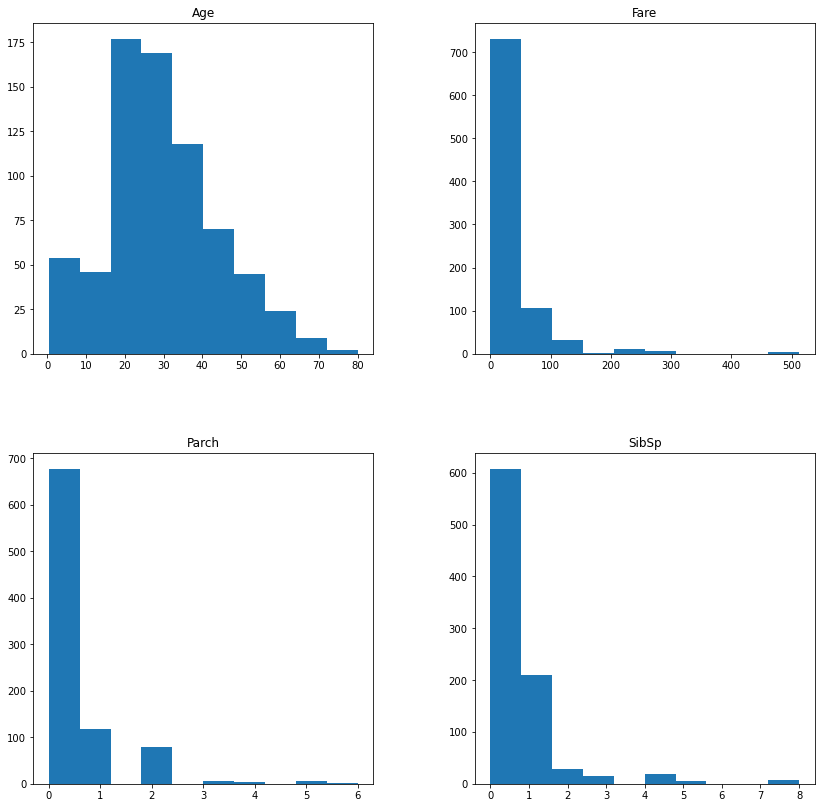

In [187]:
train_num.hist(figsize=[14,14], grid=False)

In [188]:
# let's count the percentage of passengers with the age between 20-30
count_2030 = (train_num['Age'][(train_num['Age'] <= 30) & (train_num['Age'] >= 20)].count())/(train_num['Age'].count())
print(count_2030*100)
print("There are {:.2f} percent of people who were aged 20-30".format(count_2030*100))
# do the same for other 3 numerical features
count_zerosib = (train_num['SibSp'][(train_num['SibSp'] == 0)].count())/(train_num['Age'].count())
print("There are {:.2f} percent of people who had no siblings and spouse accompanying them".format(count_zerosib*100))

count_mostfare = (train_num['Fare'][(train_num['Fare'] <= 100) & (train_num['Fare'] >= 0)].count())/(train_num['Fare'].count())
print("There are {:.2f} percent of people who paid between 0 and 100 pounds".format(count_mostfare*100))

count_mostparch = (train_num['Parch'][(train_num['Parch'] == 0)].count())/(train_num['Parch'].count())
print("There are {:.2f} percent of people who had no parents and children accompanying them".format(count_mostparch*100))

34.31372549019608
There are 34.31 percent of people who were aged 20-30
There are 85.15 percent of people who had no siblings and spouse accompanying them
There are 94.05 percent of people who paid between 0 and 100 pounds
There are 76.09 percent of people who had no parents and children accompanying them


In general:
1. Most people are aged 20-30 (34.41%)
2. Most have 0 siblings and spouses (85.11%)
3. Most have 0 parents/children with them. (76.04%)
4. The fare is highly skewed towards 0-100.(94.04%)

The data is heavily skewed, so we can consider the normalization in the preprocessing.

# Categorical data overview

In [189]:
print("There were {} males and {} females in the cabin.".format(train_cat['Sex'].value_counts().male, train_cat['Sex'].value_counts().female))

There were 577 males and 314 females in the cabin.


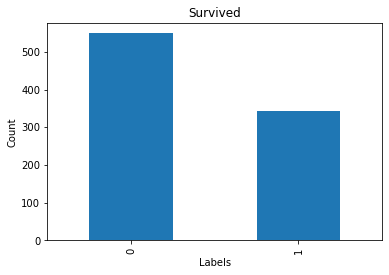

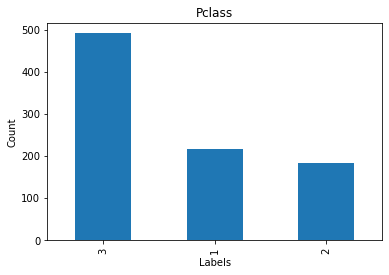

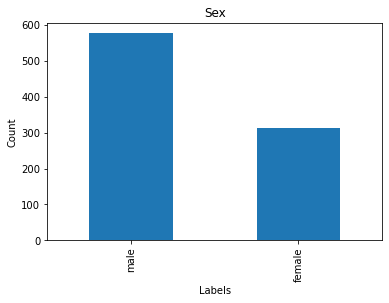

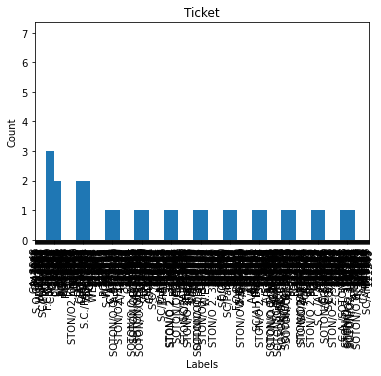

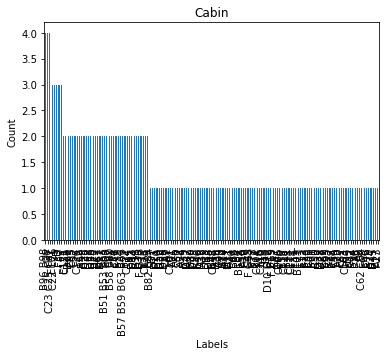

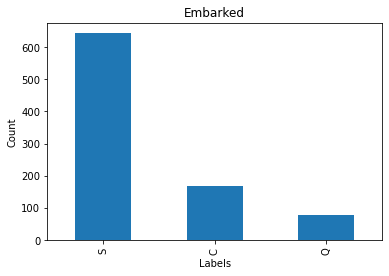

In [190]:
for j in train_cat.columns:
    plt.figure()
    ax = train_cat[j].value_counts().plot(kind='bar', title=j)
    ax.set_ylabel('Count')
    ax.set_xlabel('Labels')

The ticket and cabin features are quite messy with too many labels. Feature engineering will help in this case. For the time being, we will not use those two features to determine the correlation between the Survived column and those columns.

# Finding the correlation between each features and whether the person will survive

Let's do another quick plot session to visualize between "Survived" and any other columns. This can also be done using pivotal table, but I chose to do it with the bar plot instead.

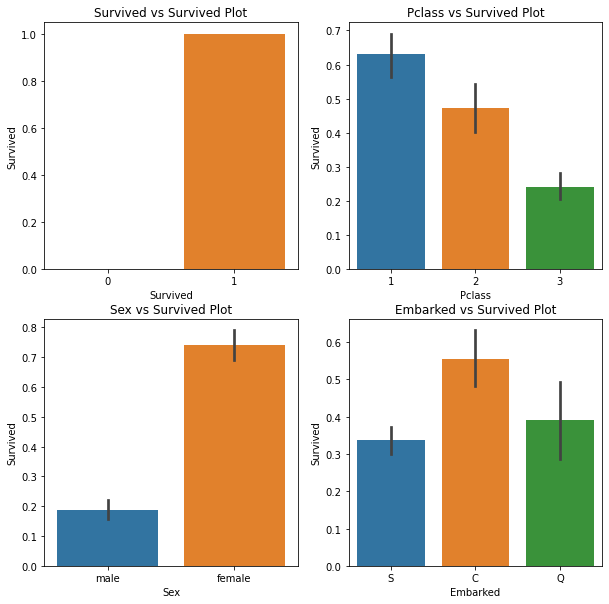

In [191]:
# We don't need the ticket and cabin features yet.
train_cat_plot = train_cat.drop(['Ticket', 'Cabin'], axis=1)
fig = plt.figure(figsize=[10,10])
# make plots using all other features
for i, j in enumerate(train_cat_plot.columns):
    fig.add_subplot(2,2, i+1)
    sns.barplot(x=j, y='Survived', data=train_cat_plot)
    plt.title('{} vs Survived Plot'.format(j))

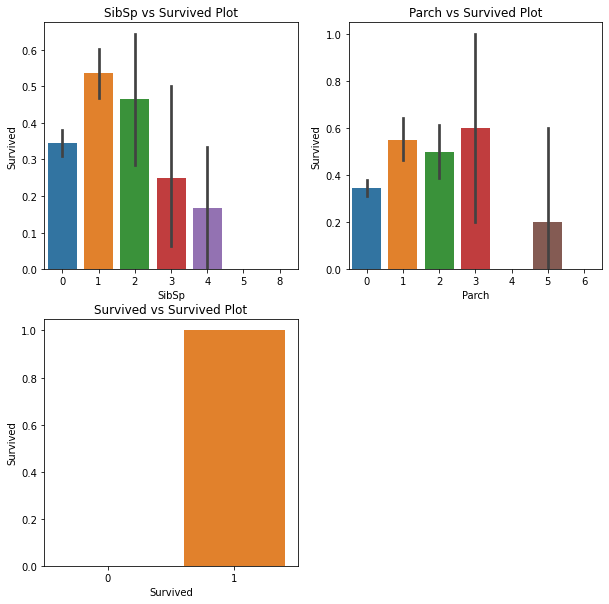

In [192]:
# also plot the numerical data
train_num_plot = train_num = train[['SibSp','Parch', 'Survived']]
fig = plt.figure(figsize=[10,10])
# make plots using all other features
for i, j in enumerate(train_num_plot.columns):
    fig.add_subplot(2,2, i+1)
    sns.barplot(x=j, y='Survived', data=train_num_plot)
    plt.title('{} vs Survived Plot'.format(j))

In [193]:
#print percentages of females vs. males that survive
print("Percentage of females who survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)

print("Percentage of males who survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

#print percentage of people by Pclass that survived
print("Percentage of Pclass = 1 who survived:", train["Survived"][train["Pclass"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 2 who survived:", train["Survived"][train["Pclass"] == 2].value_counts(normalize = True)[1]*100)

print("Percentage of Pclass = 3 who survived:", train["Survived"][train["Pclass"] == 3].value_counts(normalize = True)[1]*100)

Percentage of females who survived: 74.20382165605095
Percentage of males who survived: 18.890814558058924
Percentage of Pclass = 1 who survived: 62.96296296296296
Percentage of Pclass = 2 who survived: 47.28260869565217
Percentage of Pclass = 3 who survived: 24.236252545824847


Quick insights:
1. Ignore the top left plot, because it's just a survived vs survived plot.
2. First class passengers are the most likely to survive (because the first class cabin was on the upper part of the ship so they were able to escape quicker?). There is positive correlation between the survivability and the higher passenger class.
3. Females are more likely to survive than males, because the emergency ship was prioritized for women and children (no surprising facts here).
4. People embarking from Cherbourg survives the most, but the correlation is not very clear.

# Handling Missing and Duplicate Data
The EDA helps us to choose the treatment for the missing data. 

In [194]:
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
train_test        0
dtype: int64

We can't do anything yet to the ticket and cabin features before we do some feature engineering. However, we can just impute the missing value in Fare, Age, and Embarked columns

In [195]:
all_data.Age = all_data.Age.fillna(train.Age.median()) # we use median because of some outliers.
all_data.Fare = all_data.Fare.fillna(train.Fare.median())
all_data = all_data.dropna(subset=['Embarked'])

The missing values should be dealt with now.

In [196]:
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
train_test        0
dtype: int64

In [197]:
# Now handling duplicates
all_data.duplicated().sum()

0

In [198]:
# drop passenger id
all_data = all_data.drop(['PassengerId'], axis=1)

No duplicate rows, so we should be fine moving forward.

# Correlation plot
Now let's combine the data to gain insights on the predictor and the target relationship. This also prevents data leakage in the model (source: https://towardsdatascience.com/preventing-data-leakage-in-your-machine-learning-model-9ae54b3cd1fb). We won't peek the test data, though.

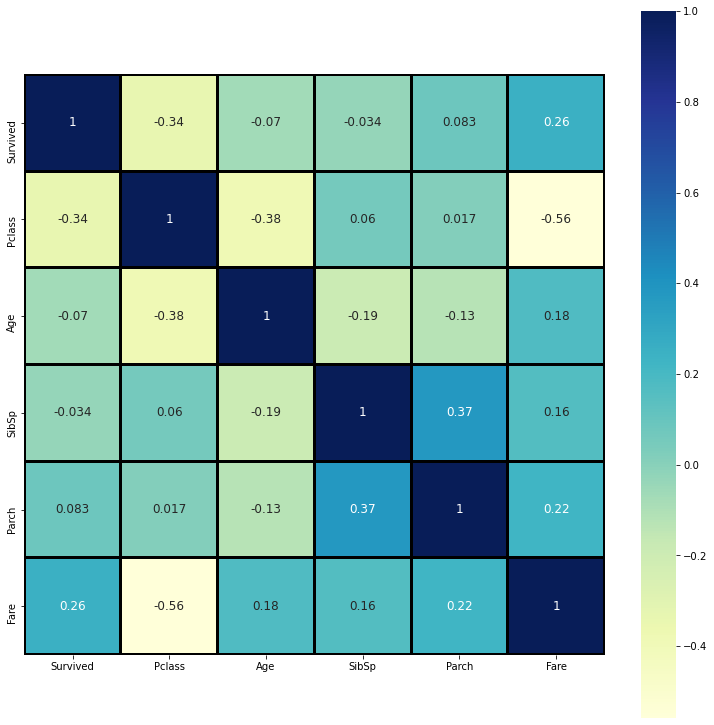

In [199]:
all_data_corrplot = all_data.drop(['train_test'], axis=1)
fig, axs = plt.subplots(nrows=1, figsize=(13, 13))
sns.heatmap(all_data_corrplot.corr(), annot=True, square=True, cmap='YlGnBu', linewidths=2, linecolor='black', annot_kws={'size':12})

It can be seen that the passenger class has some negative correlation with the survival (-0.34). Lower Pclass means higher passenger class. Passenger class also has some correlation with the fare, which makes sense since the higher the passenger class, the more expensive people have to pay.

# Feature Engineering

# Tweaking the name feature
The name was organized in the following pattern:

Braund, Mr. Owen Harris

Name, "title". Name

What we want to do is to extract the "title".

The first thing to do is to split by ,

**The second thing is to split by . so we get only the title.


In [200]:
all_data['name_title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [201]:
all_data['name_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [202]:
all_data['name_title'].value_counts()

Mr              757
Miss            259
Mrs             196
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Lady              1
the Countess      1
Jonkheer          1
Capt              1
Mme               1
Don               1
Sir               1
Dona              1
Name: name_title, dtype: int64

In [203]:
# Replacing less familiar names with more familiar names
all_data['name_title'] = all_data['name_title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer')
all_data['name_title'] = all_data['name_title'].replace(['Jonkheer', 'Master'], 'Master')
all_data['name_title'] = all_data['name_title'].replace(['Don', 'Sir', 'the Countess', 'Lady', 'Dona'], 'Royalty')
all_data['name_title'] = all_data['name_title'].replace(['Mme', 'Ms', 'Mrs'], 'Mrs')
all_data['name_title'] = all_data['name_title'].replace(['Mlle', 'Miss'], 'Miss')
  

# Imputing missing values with 0
all_data['name_title'] = all_data['name_title'].fillna(0)

all_data['name_title'].value_counts()

Mr         757
Miss       261
Mrs        199
Master      62
Officer     23
Royalty      5
Name: name_title, dtype: int64

Text(0, 0.5, 'Count')

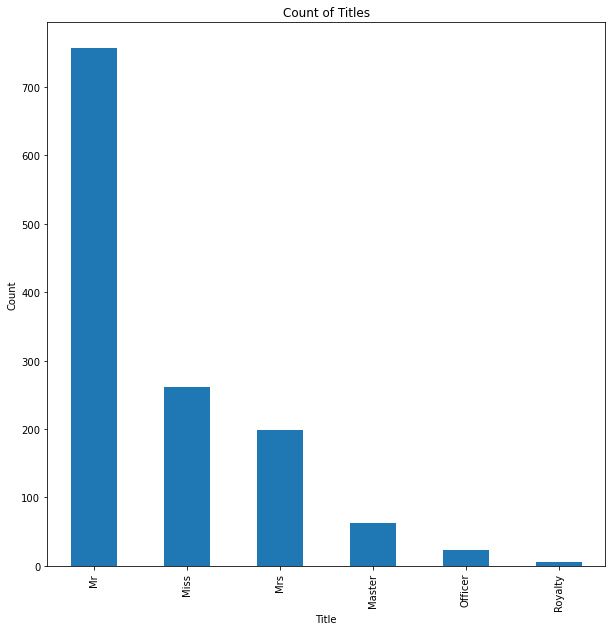

In [204]:
plt.figure(figsize=[10,10])
all_data['name_title'].value_counts().plot(kind='bar')
plt.title('Count of Titles')
plt.xlabel('Title')
plt.ylabel('Count')

# Engineering the cabin feature
There are a lot of missing data in the cabin feature, most likely because most people don't stay in a particular cabin, or an economic cabin is not classified in the data.

In [205]:
all_data['Cabin'] = all_data['Cabin'].fillna('Unknown')
all_data['Deck'] = all_data['Cabin'].str.get(0)

Text(0.5, 1.0, 'Deck Category vs Survived Plot')

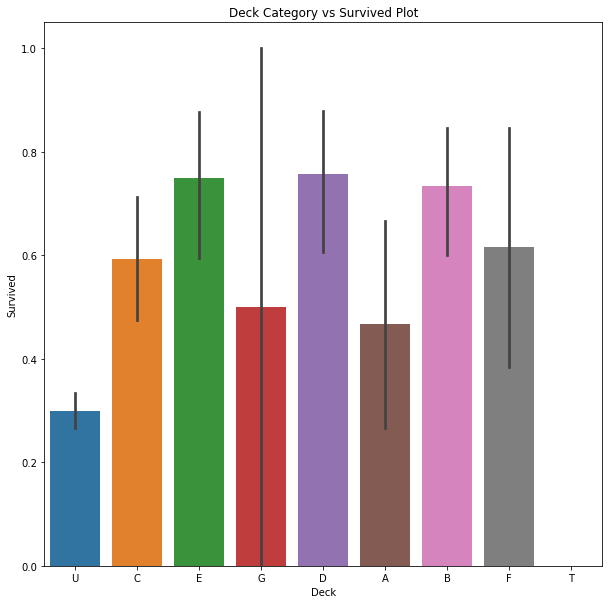

In [206]:
plt.figure(figsize=[10, 10])
sns.barplot(x=all_data['Deck'], y='Survived', data=all_data)
plt.title('Deck Category vs Survived Plot')

# Engineering the Ticket Feature
The ticket formatting is weird, because some have numbers only while some others also have letters before the numbers.

In [207]:
all_data['ticket_numeric'] = all_data['Ticket'].apply(lambda x: 1 if x.isnumeric() else 0)

Text(0.5, 1.0, 'Is the ticket numeric only? vs Survived Plot')

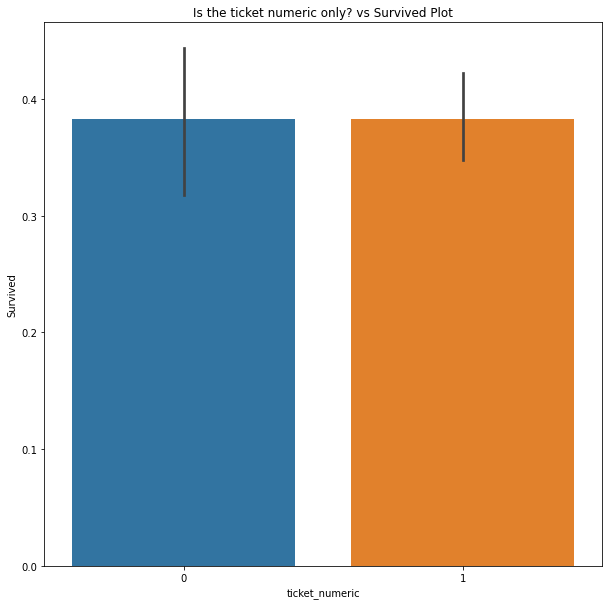

In [208]:
plt.figure(figsize=[10, 10])
sns.barplot(x=all_data['ticket_numeric'], y='Survived', data=all_data)
plt.title('Is the ticket numeric only? vs Survived Plot')

# Number of family members
SibSp and Parch seems redundant, so we can just combine them.

In [209]:
all_data['num_family_member'] = all_data['SibSp'] + all_data['Parch']

In [210]:
all_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test,name_title,Deck,ticket_numeric,num_family_member
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknown,S,1,Mr,U,0,1
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,C,0,1
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknown,S,1,Miss,U,0,0
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,C,1,1
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknown,S,1,Mr,U,1,0


# Dropping unnecessary columns
> Now we have done our feature engineering by adding 3 new columns, now we can delete the unnecessary features.

In [211]:
all_data = all_data.drop(['Name','SibSp', 'Parch', 'Ticket', 'Cabin', 'train_test'], axis=1)

In [212]:
all_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,name_title,Deck,ticket_numeric,num_family_member
0,0.0,3,male,22.0,7.2500,S,Mr,U,0,1
1,1.0,1,female,38.0,71.2833,C,Mrs,C,0,1
2,1.0,3,female,26.0,7.9250,S,Miss,U,0,0
3,1.0,1,female,35.0,53.1000,S,Mrs,C,1,1
4,0.0,3,male,35.0,8.0500,S,Mr,U,1,0


# Normalize some values
Before splitting the train-test set, we need to normalize the numerical values altogether so the normalization process can be uniform between train and test data.

In [218]:
scale = StandardScaler()
all_data_scaled = all_data.copy()
all_data_scaled[['Age','num_family_member','ticket_numeric','Fare']]= scale.fit_transform(all_data_scaled[['Age','num_family_member','ticket_numeric','Fare']])

# Encode the categorical features

In [220]:
all_data.dtypes

Survived             float64
Pclass                 int64
Sex                   object
Age                  float64
Fare                 float64
Embarked              object
name_title            object
Deck                  object
ticket_numeric         int64
num_family_member      int64
dtype: object

In [223]:
all_data_encoded = all_data_scaled
for j in ['Sex', 'Embarked', 'name_title', 'Deck']:
    all_data_encoded[j] = all_data_encoded[j].astype('category')
    all_data_encoded[j] = all_data_encoded[j].cat.codes

In [224]:
all_data_encoded.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,name_title,Deck,ticket_numeric,num_family_member
0,0.0,3,1,-0.580261,-0.501839,2,2,8,-1.647139,0.072460
1,1.0,1,0,0.662297,0.736023,0,3,2,-1.647139,0.072460
2,1.0,3,0,-0.269621,-0.488790,2,1,8,-1.647139,-0.558906
3,1.0,1,0,0.429318,0.384512,2,3,2,0.607113,0.072460
4,0.0,3,1,0.429318,-0.486373,2,2,8,0.607113,-0.558906


# Train - Test split

In [246]:
train_data = all_data[:len(train)-2] # because we dropped 2 column back in embarked column missing value
test_data = all_data[len(train)-2:]
print("Dimension of train data is: ", train_data.shape)
print("Dimension of test data is: ", test_data.shape)

Dimension of train data is:  (889, 10)
Dimension of test data is:  (418, 10)


In [243]:
X_train_scaled = train_data.drop(['Survived'], axis=1)
y_train_scaled = train_data['Survived']
X_test_scaled = test_data.drop(['Survived'], axis=1)
y_test_scaled = test_data['Survived']

In [244]:
X_train_scaled.head()

,Pclass,Sex,Age,Fare,Embarked,name_title,Deck,ticket_numeric,num_family_member
0,3,1,22.0,7.2500,2,2,8,0,1
1,1,0,38.0,71.2833,0,3,2,0,1
2,3,0,26.0,7.9250,2,1,8,0,0
3,1,0,35.0,53.1000,2,3,2,1,1
4,3,1,35.0,8.0500,2,2,8,1,0


# Model Building
There are 5 models that I use in this project:
1. Naive Bayes
2. K-Nearest Neighbor
3. Support Vector Machine
4. XGBoost
5. Random Forest

In [258]:
# NB model
print("The CV mean score for Naive Bayes model is {:.3f}".format(cross_val_score(GaussianNB(), X_train_scaled, y_train_scaled).mean()))

The CV mean score for Naive Bayes model is 0.792


In [257]:
# KNN model
print("The CV mean score for K Nearest Neighbor model is {:.3f}".format(cross_val_score(KNeighborsClassifier(), X_train_scaled, y_train_scaled).mean()))

The CV mean score for K Nearest Neighbor model is 0.697


In [256]:
# SVM model
print("The CV mean score for Support Vector Machine model is {:.3f}".format(cross_val_score(SVC(), X_train_scaled, y_train_scaled).mean()))

The CV mean score for Support Vector Machine model is 0.669


In [255]:
# XGBoost model
print("The CV mean score for XGBoost model is {:.3f}".format(cross_val_score(XGBClassifier(), X_train_scaled, y_train_scaled).mean()))

The CV mean score for XGBoost model is 0.829


In [259]:
# RF model
print("The CV mean score for Random Forest model is {:.3f}".format(cross_val_score(RandomForestClassifier(), X_train_scaled, y_train_scaled).mean()))

The CV mean score for Random Forest model is 0.812


The recap:
* Naive Bayes (79.2%)
* KNN (69.7%)
* SVM (66.9%)
* <b> XGBoost (82.9%) </b>
* Random Forest (81.2%)

# We try to use the XGBoost method.

In [261]:
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train_scaled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [271]:
y_pred = xgb.predict(X_test_scaled).astype('int32')

In [272]:
print(y_pred.shape)

(418,)


In [273]:
final_result = {'PassengerId': test['PassengerId'], 'yhat': y_pred}

In [275]:
final_dataframe = pd.DataFrame(final_result)

In [ ]:
final_dataframe.to_csv('submission.csv')